# 2022 EY Data Science Challenge
## Model Building - Level 1


| Challenge | Locations                     | Spatial Res        | Model             | Species | Satellite Data                                                |
|-----------|-------------------------------|--------------------|-------------------|---------|---------------------------------------------------------------|
|***1***    | Australia                     | Coarse (res=1000)  |Logistic Regression| Pooled  | Weather Data                                                  |
| 2         | Australia, Costa Rica         | Moderate (res=100) |Random Forest      | Pooled  | Weather Data, Sentinel-2                                      |
| 3         | Australia, Costa Rica,<br>Europe | Fine (res=10)   |Neural Network     | Pooled  | Weather Data, Sentinel-2,<br>Land cover, water extent, elevation |


In this notebook, we will develop a logistic regression model to predict frog occurrences using solely [TerraClimate](https://planetarycomputer.microsoft.com/dataset/terraclimate) data. 


In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt

# Data science
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import LogisticRegression

# Geospatial
import geopandas as gpd
import contextily as cx
from shapely.geometry import Point, Polygon
import xarray as xr
import rasterio.features
import rasterio as rio
import fsspec

# API
import requests
import json

# Import Planetary Computer
import stackstac
import pystac
import pystac_client
import planetary_computer


### Gathering Data for Richmond, NSW

For this demonstration, we will constrain our search to frogs in the Richmond NSW area. 

Text(0.5, 1.0, 'Richmond, NSW')

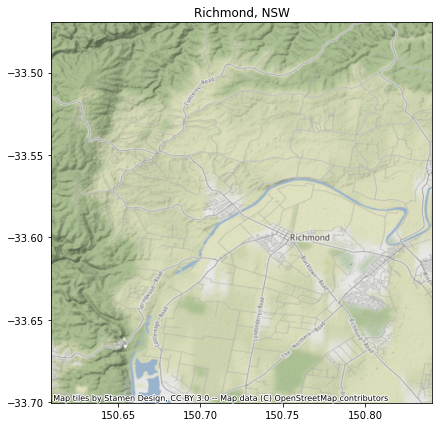

In [2]:
# Richmond, NSW
min_lon, min_lat = (150.62, -33.69)  # Lower-left corner
max_lon, max_lat = (150.83, -33.48)  # Upper-right corner
bbox = (min_lon, min_lat, max_lon, max_lat)

# Plot map of region
crs = {'init':'epsg:4326'}
fig, ax = plt.subplots(figsize = (7, 7))
ax.scatter(x=[min_lon, max_lon], y=[min_lat, max_lat], alpha=0)
cx.add_basemap(ax, crs=crs)
ax.set_title('Richmond, NSW')

#### Fetching Frog Response Variable
Firstly, we need to query the GBIF API to obtain the frog occurrence data for the Richmond area. We wrap up this process in the `get_frogs` function. In addition, the process of getting the frog absence data is wrapped up in the `get_frog_absence` data. These two functions combined will give us our response variable dataframe.

In [3]:
def get_frogs(bbox, query_params={}, crs={'init':'epsg:4326'}, orderKey="952", verbose=False):
    """Returns the dataframe of frog occurrences for the bounding box specified.
    
    Arguments:
    bbox -- tuple of (min_lon, min_lat, max_lon, max_lat)
    query_params -- dictionary of query parameters to pass to the GBIF API search function
    crs -- dictionary of the coordinate reference system, defaults to {'init':'epsg:4326'}
    orderKey -- string of the taxonomic key for order, for frogs this is '952'
    verbose -- boolean. If true, will print progress markers 
    """
    
    # Set query parameters
    min_lon, min_lat, max_lon, max_lat = bbox
    limit = 300
    offset = 0
    parameters = {
        **query_params,
        "orderKey":orderKey, # The order Anura (frogs) is indicated by key 952
        "decimalLatitude":f"{min_lat},{max_lat}", # Latitude range
        "decimalLongitude":f"{min_lon},{max_lon}", # Longitude range
        "limit":limit,
        "offset":offset
    }
    
    # Query API
    frogs = pd.DataFrame()
    while True:
        # Fetch results
        parameters['offset'] = offset
        response = requests.get("https://api.gbif.org/v1/occurrence/search", params = parameters).json()
        total = response['count']
        
        # Print progress
        print(f"{offset} of {total}") if verbose else None
        
        # Add results to dataframe
        frogs = frogs.append(
            pd.DataFrame(response['results'])
            [["decimalLatitude", "decimalLongitude"]]
            .assign(
                occurrenceStatus = 1
            )
        )
        if response['endOfRecords']:
            break
        offset += limit
        
    geo_frogs = gpd.GeoDataFrame(
        frogs.reset_index(drop=True), 
        geometry=gpd.points_from_xy(frogs.decimalLongitude, frogs.decimalLatitude),
        crs=crs
    )
    return geo_frogs


In [4]:

def get_frog_absence(geo_frogs, bbox, crs = {'init':'epsg:4326'}, granularity=(50, 50), seed=420):
    """Returns a dataframe complete with frog-absence data
    
    Granularity must be sufficiently fine such that there are at least as many non-frog observations
    as frog observations. This may require some trial and error.
    
    Arguments:
    geo_frogs -- geopandas dataframe of frogs, outputted from get_frogs function
    bbox -- tuple of (min_lon, min_lat, max_lon, max_lat)
    crs -- dictionary of the coordinate reference system, defaults to {'init':'epsg:4326'}
    granularity -- 2D tuple of the grid dimensions to divide the bounding box into - (ydim, xdim)
    seed -- random seed for reproducable resampling
    """
    # bbox definition
    min_lon, min_lat, max_lon, max_lat = bbox
    
    # Specify granularity of grid (50x50)
    grid = np.array(granularity)
    
    # Calculate the step required to achieve granularity
    step = np.array([max_lat - min_lat, max_lon - min_lon])/grid
    
    # Define unit vectors
    up = np.array([0, 1])
    right = np.array([1, 0])
    
    # Bottom corner of entire bounding box
    bbox_bottom_corner = np.array([min_lon, min_lat])
    
    # bottom corner of grid unit
    bottom_corner = bbox_bottom_corner
    
    non_frogs = pd.DataFrame()
    for i in range(grid[0]):
        for j in range(grid[1]):
            # Define grid unit
            coords = [
                tuple(bottom_corner), 
                tuple(bottom_corner + step*up), 
                tuple(bottom_corner + step), 
                tuple(bottom_corner + step*right)
            ]
            grid_unit = Polygon(coords)
            
            # count all frogs that intersect with this region
            num_frogs = sum(geo_frogs.intersects(grid_unit))
            if num_frogs == 0:
                midpoint = bottom_corner + step/2
                non_frogs = non_frogs.append({'decimalLatitude':midpoint[1], 'decimalLongitude':midpoint[0]}, ignore_index=True)
                
            # move bottom corner to next grid unit
            bottom_corner = bbox_bottom_corner + step*np.array([i, j])
    np.random.seed(seed)
    non_frogs = (
        non_frogs
        # Take as many non-frogs as there are frogs
        .sample(len(geo_frogs))
        # Assign new columns
        .assign(
            occurrenceStatus = '0'
        )
        [[ "decimalLatitude", "decimalLongitude", "occurrenceStatus"]]
    )
    geo_non_frogs = gpd.GeoDataFrame(
        non_frogs, 
        geometry=gpd.points_from_xy(non_frogs.decimalLongitude, non_frogs.decimalLatitude),
        crs=crs
    )
    all_frogs = (
        geo_frogs.append(geo_non_frogs)
        .reset_index(drop=True)
        .reset_index()
        .rename(columns={'index':'key'})
    )
    return all_frogs


In [5]:
frog_data = get_frogs(bbox, {"year":"1800,2022"}, verbose=True)
frog_data = get_frog_absence(frog_data, bbox)
frog_data

0 of 1456
300 of 1456
600 of 1456
900 of 1456
1200 of 1456


,key,decimalLatitude,decimalLongitude,occurrenceStatus,geometry
0,0,-33.640336,150.687247,1,POINT (150.68725 -33.64034)
1,1,-33.609240,150.748344,1,POINT (150.74834 -33.60924)
2,2,-33.687430,150.708166,1,POINT (150.70817 -33.68743)
3,3,-33.567792,150.790437,1,POINT (150.79044 -33.56779)
4,4,-33.629142,150.713045,1,POINT (150.71304 -33.62914)
...,...,...,...,...,...
2907,2907,-33.490500,150.739700,0,POINT (150.73970 -33.49050)
2908,2908,-33.540900,150.622100,0,POINT (150.62210 -33.54090)
2909,2909,-33.637500,150.647300,0,POINT (150.64730 -33.63750)
2910,2910,-33.557700,150.722900,0,POINT (150.72290 -33.55770)


#### Fetching predictor variables
Next, we write a function called `get_terraclimate` to fetch the terraclimate data. This function will fetch all data intersecting with the bounding box and will calculate various metrics over the time dimension for each coordinate. In this example, we will take six metrics from four assets, namely the mean and overall maximum monthly air temp (`tmax_mean`, `tmax_max`), mean and overall minimum monthly air temp (`tmin_mean`, `tmin_min`), mean accumulated precipitation (`ppt_mean`) and mean soil moisture (`soil_mean`), all calculated over a five year timeframe from the start of 2015 to the end of 2019.

To assist in visualisations, this function has an interpolation functionality which will allow the comparitively coarse temporal resolution of the terraclimate data to be mapped to a larger set of coordinates, creating an $(n\times m)$ image. We will choose $(512\times 512)$.


In [6]:
def get_terraclimate(bbox, metrics, time_slice=None, assets=None, features=None, interp_dims=None):
    """Returns terraclimate metrics for a given area, allowing results to be interpolated onto a larger image.
    
    Attributes:
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    metrics -- Nested dictionary in the form {<metric_name>:{'fn':<metric_function>,'params':<metric_kwargs_dict>}, ... }
    time_slice -- Tuple of datetime strings to select data between, e.g. ('2015-01-01','2019-12-31')
    assets -- list of terraclimate assets to take
    features -- list of asset metrics to take, specified by strings in the form '<asset_name>_<metric_name>'
    interp_dims -- Tuple of dimensions (n, m) to interpolate results to
    """
    min_lon, min_lat, max_lon, max_lat = bbox
    
    collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
    asset = collection.assets["zarr-https"]
    store = fsspec.get_mapper(asset.href)
    data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
    
    # Select datapoints that overlap region
    if time_slice is not None:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=slice(time_slice[0],time_slice[1]))
    else:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat))
    if assets is not None:
        data = data[assets]
    data = data.rename(lat='y', lon='x').to_array().compute()
        
    # Calculate metrics
    combined_values = []
    combined_bands = []
    for name, metric in metrics.items():
        sum_data = xr.apply_ufunc(
            metric['fn'], data, input_core_dims=[["time"]], kwargs=metric['params'], dask = 'allowed', vectorize = True
        ).rename(variable='band')
        xcoords = sum_data.x
        ycoords = sum_data.y
        dims = sum_data.dims
        combined_values.append(sum_data.values)
        for band in sum_data.band.values:
            combined_bands.append(band+'_'+name)
        
    # Combine metrics
    combined_values = np.concatenate(
        combined_values,
        axis=0
    )
    combined_data = xr.DataArray(
        data=combined_values,
        dims=dims,
        coords=dict(
            band=combined_bands,
            y=ycoords,
            x=xcoords
        )
    )    

    # Take relevant bands:
    combined_data = combined_data.sel(band=features)
    
    if interp_dims is not None:
        interp_coords = (np.linspace(bbox[0], bbox[2], interp_dims[0]), np.linspace(bbox[1], bbox[3], interp_dims[1]))
        combined_data = combined_data.interp(x=interp_coords[0], y=interp_coords[1], method='nearest', kwargs={"fill_value": "extrapolate"})
    
    return combined_data

In [7]:
# Metrics to measure over time dimension
metrics = {
    'mean':{
        'fn':np.nanmean,
        'params':{}
    },
    'min':{
        'fn':np.nanmin,
        'params':{}
    },
    'max':{
        'fn':np.nanmax,
        'params':{}
    }
}

# Date range to take
time_slice = ('2015-01-01','2019-12-31')

# Measurements to take
assets=['tmax', 'tmin', 'ppt', 'soil']

# Features to take, in form '<asset>_<metric>'
features=['tmax_max', 'tmax_mean', 'tmin_min', 'tmin_mean', 'ppt_mean', 'soil_mean']

# Interpolate values to a 512x512 image
interp_dims = (512, 512)

weather_data = get_terraclimate(bbox, metrics, time_slice=time_slice, assets=assets, features=features, interp_dims=interp_dims)
display(weather_data.band.values)

array(['tmax_max', 'tmax_mean', 'tmin_min', 'tmin_mean', 'ppt_mean',
       'soil_mean'], dtype='<U9')

The six variables over the Richmond region are displayed below.

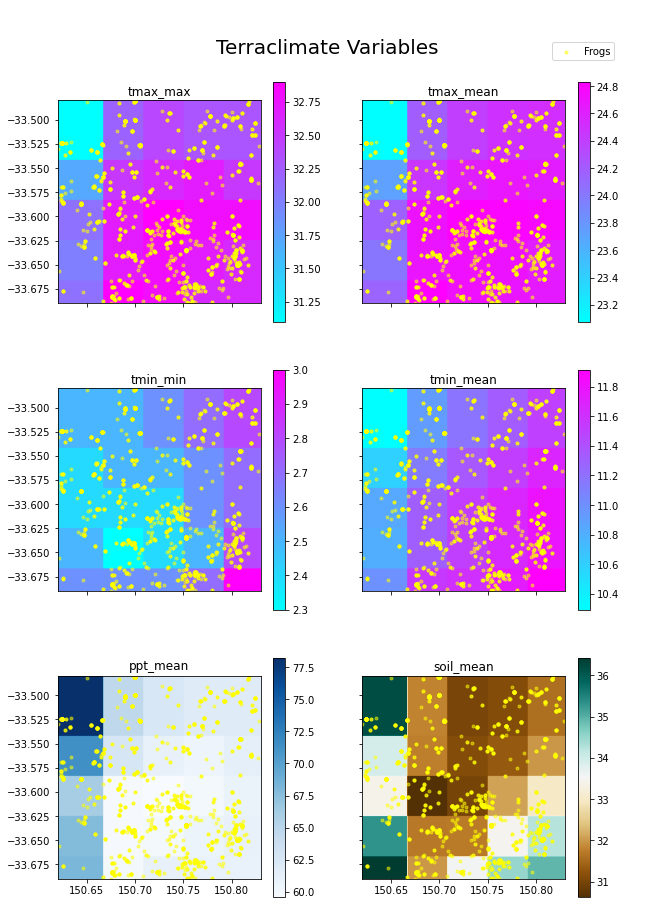

In [8]:
nrow = 3
ncol = 2
fig, ax = plt.subplots(nrow, ncol, figsize=(10, 15), sharex=True, sharey=True)

bands = weather_data.band.values
filt = frog_data.occurrenceStatus == 1
extent = [bbox[0], bbox[2], bbox[1], bbox[3]]
cmaps = ["cool", "cool", "cool", "cool", "Blues", "BrBG"]

for i in range(len(bands)):
    img = ax[i//ncol, i%ncol].imshow(weather_data[i, :, :], cmap=cmaps[i], extent=extent, origin='lower')
    ax[i//ncol, i%ncol].set_title(bands[i])
    ax[i//ncol, i%ncol].scatter(frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude,
                                color = 'yellow', marker='.', alpha=0.5, label='Frogs' if i==0 else '')
    
    # ax[i//ncol, i%ncol].scatter(weather_data[i].idxmax('x'),weather_data[i].idxmax('y'), color='black', marker='*', s=40)
    
    fig.colorbar(img, ax=ax[i//ncol, i%ncol])

fig.suptitle("Terraclimate Variables", x=0.5, y=0.92, fontsize=20)
fig.legend(loc=(0.85, 0.933))

##### Joining Features to Response Variable

Now that we have read in both our response and predictor variables, we now need to join them onto the response variable of frogs. To do this, we loop through the frog occurrence data and assign each frog occurrence the closest predictor pixel value from each of the predictor variables based on the geo-coordinates. The `sel` method of the xarray dataarray comes in handy here.

In [9]:
def join_features(model_data, predictor_image):
    """Joins the features from each feature dataset onto each response variable. 

    Arguments:
    model_data -- dataframe containing the response variable along with ["decimalLongitude", "decimalLatitude", "key"]
    all_datasets -- list of feature datasets stored as xarray dataarrays, indexed with geocoordinates
    """
    # For each latitude and longitude coordinate, find the nearest predictor variable pixel values
    data_per_point = pd.DataFrame()
    for j, (lon, lat, key) in enumerate(zip(model_data.decimalLongitude, model_data.decimalLatitude, model_data.key)):
        # Print out some progress markers
        if (j+1)%500==0:
            print(f"{j+1} of {len(model_data)}")

        # Get the predictor pixel at the site of the frog occurrence
        nearest_point = predictor_image.sel(y=lat, x=lon, method="nearest")

        # Prepare values and columns and save them in a dataframe, saving the join key for later reference
        values = np.concatenate((np.squeeze(nearest_point.values), np.array([key])))
        columns = list(nearest_point.band.values) + ['key']
        data_per_point = data_per_point.append(
            pd.DataFrame(
                np.array([values]), 
                columns=columns
            )
        )

    # Join the predictor variables we just collected back onto the frog data
    model_data = model_data.merge(
        data_per_point,
        on = ['key'],
        how = 'inner'
    )
        
    return model_data

model_data = join_features(frog_data, weather_data)
model_data.head()

500 of 2912
1000 of 2912
1500 of 2912
2000 of 2912
2500 of 2912


,key,decimalLatitude,decimalLongitude,occurrenceStatus,geometry,tmax_max,tmax_mean,tmin_min,tmin_mean,ppt_mean,soil_mean
0,0,-33.640336,150.687247,1,POINT (150.68725 -33.64034),32.700005,24.691671,2.299999,11.318334,59.716667,31.700001
1,1,-33.609240,150.748344,1,POINT (150.74834 -33.60924),32.900002,24.811666,2.400002,11.521668,59.566666,31.000000
2,2,-33.687430,150.708166,1,POINT (150.70817 -33.68743),32.800003,24.716669,2.600002,11.606668,60.916668,33.549999
3,3,-33.567792,150.790437,1,POINT (150.79044 -33.56779),32.700005,24.668337,2.600002,11.516667,60.466667,31.316668
4,4,-33.629142,150.713045,1,POINT (150.71304 -33.62914),32.800003,24.720001,2.400002,11.513335,59.916668,31.716667


#### Model Training

Now that we have the data in a format appropriate for machine learning, we can begin training a model. For this demonstration notebook, we will use a basic logistic regression model from the [scikit-learn](https://scikit-learn.org/stable/) library. This library offers a wide range of other models, each with the capacity for extensive parameter tuning and customisation capabilities.

Scikit-learn models require separation of predictor variables and the response variable. We store the predictor variables in dataframe `X` and the response in the array `y`. We must make sure to drop the response variable from `X`, otherwise the model will have the answers! It also doesn't make sense to use latitude and longitude as predictor variables in such a confined area, so we drop those too.

In [10]:
full_model = LogisticRegression()
# Separate the predictor variables from the response
X = (
    model_data
    .drop(['key', 'decimalLongitude', 'decimalLatitude', 'occurrenceStatus', 'geometry'], 1)
)
y = model_data.occurrenceStatus.astype(int)


For now, we will train the model using all of our training data. Hence, this section will only reflect the in-sample performance of our model, and not the out-of-sample performance. Out-of-sample performance is crucial in estimating how a model will perform in a real world environment. We will attempt to evaluate the out-of-sample performance of this model in a later section, but for now we can have some fun visualising the in-sample performance for Richmond, NSW.

In [11]:
full_model.fit(X, y)

LogisticRegression()

#### Model Prediction

Logistic regression is a machine learning model that estimates the probability of a binary response variable. In our case, the model will output the probability of a frog being present at a given location. 


##### Heat Map
Now, we will define another function called `predict_frogs` that will take our interpolated predictor variable image in, along with our logistic regression model, and output the probabilities for each pixel.

In [12]:
def predict_frogs(predictor_image, model):
    """Returns a (1, n, m) xarray where each pixel value corresponds to the probability of a frog occurrence.
    
    Takes in the multi-band image outputted by the `create_predictor_image` function as well as the
    trained model and returns the predictions for each pixel value. Firstly, the $x$ and $y$ indexes
    in the predictor image are stacked into one multi-index $z=(x, y)$ to produce an $k\times n$
    array, which is the format required to feed into our logistic regression model. Then, the array
    is fed into the model, returning the model's predictions for the frog likelihood at each pixel. 
    The predicted probabilities are then indexed by the same multi-index $z$ as before, which allows 
    the array to be unstacked and returned as a one-band image, ready for plotting.

    Arguments:
    predictor_image -- (K, n, m) xarray, where K is the number of predictor variables.
    model -- sklearn model with K predictor variables.
    """
    # Stack up pixels so they are in the appropriate format for the model
    predictor_image = predictor_image.stack(z=("y", "x")).transpose()
    
    # Calculate probability for each pixel point 
    probabilities = model.predict_proba(
        predictor_image
    )

    # Just take probability of frog (class=1)
    probabilities = probabilities[:,1]

    # Add the coordinates to the probabilities, saving them in an xarray
    resultant_image = xr.DataArray(
        data=probabilities,
        dims=['z'],
        coords=dict(
            z=predictor_image.z
        )
    )
    # Unstack the image
    resultant_image = resultant_image.unstack()
    return resultant_image

In [13]:
# Calculate probability for each pixel point 
resultant_image = predict_frogs(weather_data, full_model)

Now that we have successfully created a one-band image of probabilities, all that is left is to visualise it. To do this, we write a function to plot a heatmap of probabilities. In addition to the heatmap, we will also plot the actual map of the area in question, and the binary classification regions of the probability heatmap. The latter is simply a binary mask of the probability heatmap, 1 where the probability is greater than 0.5 and 0 elsewhere. 

To help visualise the effectiveness of our model, we plot the frog occurrences over top of each image. This can give us an idea of where our model is doing well, and where it is doing poorly.

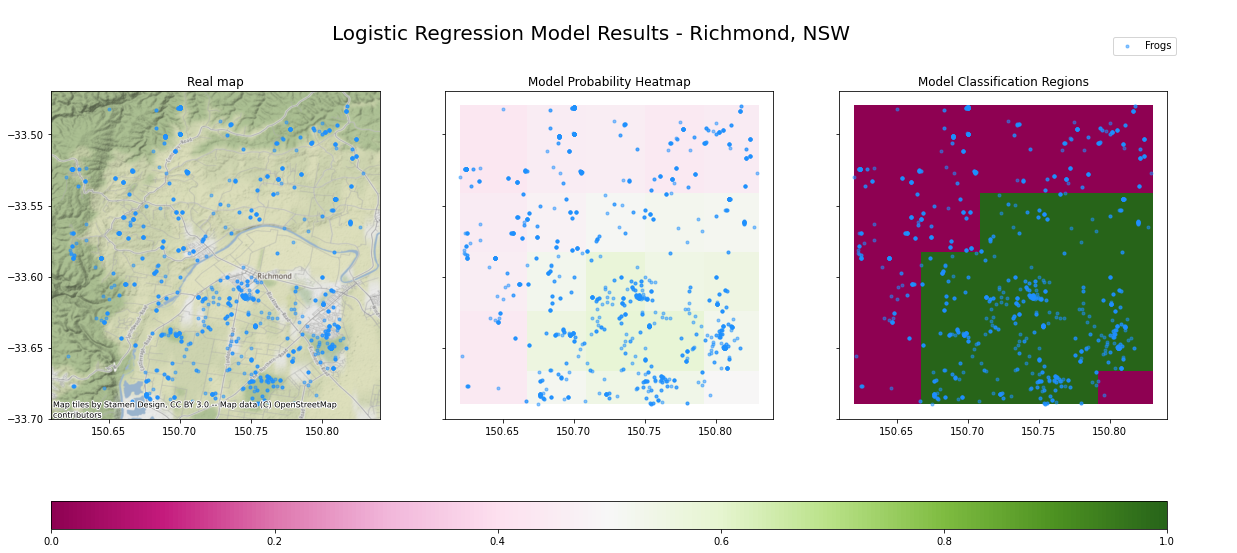

In [14]:
def plot_heatmap(resultant_image, frog_data, title, crs = {'init':'epsg:4326'}):
    """Plots a real map, probability heatmap, and model classification regions for the probability image from our model.

    Arguments:
    resultant_image -- (1, n, m) xarray of probabilities output from the model
    frog_data -- Dataframe of frog occurrences, indicated with a 1 in the occurrenceStatus column. 
                 Must contain ["occurrenceStatus", "decimalLongitude", "decimalLatitude"]
    title -- string that will be displayed as the figure title
    crs -- coordinate reference system for plotting the real map. Defaults to EPSG:4326.
    """
    fig, ax = plt.subplots(1, 3, figsize = (20, 10), sharex=True, sharey=True)
    
    bbox = [resultant_image.x.min(),resultant_image.x.max(),resultant_image.y.min(),resultant_image.y.max()]

    # Plot real map
    ax[0].scatter(x=[bbox[0], bbox[1]], y=[bbox[2], bbox[3]], alpha=0)
    cx.add_basemap(ax[0], crs=crs)
    ax[0].set_title('Real map')
    
    # Plot heatmap from model
    heatmap = ax[1].imshow(
        resultant_image, cmap='PiYG', vmin=0, vmax=1.0, interpolation='none', extent=bbox, origin='lower'
    )
    ax[1].set_title('Model Probability Heatmap')

    # Plot binary classification from model
    regions = ax[2].imshow(
        resultant_image > 0.5, cmap='PiYG', vmin=0, vmax=1.0, interpolation='none', extent=bbox, origin='lower'
    )
    ax[2].set_title('Model Classification Regions')

    # Plot real frogs
    for i, axis in enumerate(ax):
        filt = frog_data.occurrenceStatus == 1
        axis.scatter(
            frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude, 
            color = 'dodgerblue', marker='.', alpha=0.5, label='Frogs' if i==0 else ''
        )

    fig.colorbar(heatmap, ax=ax, location = 'bottom', aspect=40)
    fig.legend(loc = (0.9, 0.9))
    fig.suptitle(title, x=0.5, y=0.9, fontsize=20)
    
plot_heatmap(resultant_image, frog_data, "Logistic Regression Model Results - Richmond, NSW")

#### In-Sample Evaluation

Now that we have visualised the model on the Richmond area, we can calculate some performance metrics to guage the effectiveness of the model. Again, it must be stressed that this is the in-sample performance - the performance on the training set. Hence, the values will tend to overestimate its performance -  so don't get too excited!


In [15]:
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay

predictions = full_model.predict(X)

print(f"F1 Score: {f1_score(y, predictions)}")
print(f"Accuracy: {accuracy_score(y, predictions)}")

F1 Score: 0.5597292724196278
Accuracy: 0.553228021978022


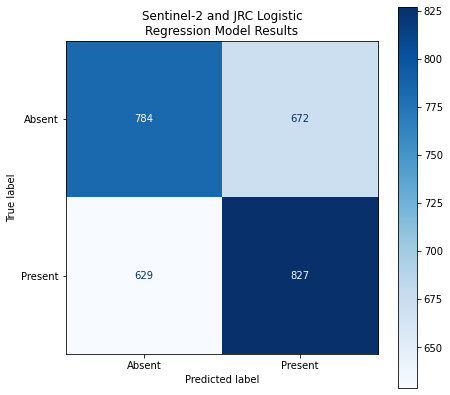

In [16]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(full_model, X, y, display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Sentinel-2 and JRC Logistic\nRegression Model Results')
plt.show()

#### Out-of-sample evaluation

When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalise. This is because models have a tendancy to overfit the dataset they are trained on. To estimate the out-of-sample performance, we will use k-fold cross-validation. This technique involves splitting the training dataset into folds, in this case we will use 10. Each iteration, the model is trained on all but one of the folds, which is reserved for testing. This is repeated until all folds have been left out once. At the end of the process, we will have 10 metrics which can be averaged, giving a more reliable and valid measure of model performance. 

`Scikit-learn` has built-in functions that can assist in k-fold cross validation. In particular, we will use `StratifiedKFold` to split our data into folds, ensuring there is always a balanced number of frogs and non-frogs in each fold.


In [17]:
from sklearn.model_selection import StratifiedKFold

cv_model = LogisticRegression()

n_folds = 10

skf = StratifiedKFold(n_splits=n_folds, random_state=420, shuffle=True)
metrics = {'F1': f1_score, 'Accuracy': accuracy_score}
results = {'F1': [], 'Accuracy': []}

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    # Split the dataset
    print(f"Fold {i+1} of {n_folds}")
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit the model with the training set
    cv_model.fit(X_train, y_train)
    
    predictions = cv_model.predict(X_test)
    
    for metric, fn in metrics.items():
        results[metric].append(fn(y_test, predictions))
        
        
print(f'\nMetrics averaged over {n_folds} trials:')
for metric, result in results.items():
    print(f"{metric}: {np.mean(result).round(2)}")
    

Fold 1 of 10
Fold 2 of 10
Fold 3 of 10
Fold 4 of 10
Fold 5 of 10
Fold 6 of 10
Fold 7 of 10
Fold 8 of 10
Fold 9 of 10
Fold 10 of 10

Metrics averaged over 10 trials:
F1: 0.56
Accuracy: 0.55
